# Regresión Logística

Para esta sesión, estaremos trabajando con el [Conjunto de datos Titanic de Kaggle](https://www.kaggle.com/c/titanic). Este es un conjunto de datos muy famoso y a menudo se utiliza para introducir a estudiantes al Aprendizaje de Máquina (Machine Learning)! 

Trataremos de predecir una clasificación - supervivencia o fallecimiento.
Iniciemos nuestra comprensión de la implementación de la Regresión Logística con Python para clasificar.

Utilizaremos una versión "semi-limpia" del conjunto de datos Titanic.  NOTA:  Si decide utilizar el conjunto de datos directamente de Kaggle, puede que necesite hacer más limpieza de la que estaremos haciendo acá.


## Importar Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Los datos

In [3]:
datos = pd.read_csv('titanic3.csv')

In [ ]:
datos.head()

In [ ]:
datos.tail()

# Análisis Exploratorio de Datos (EDA)

Empezaremos con el chequeo por datos faltantes!

## Datos faltantes

Hemos visto varias formas de hacerlo, para algo diferente, utilizaremos **Seaborn** para crear un mapa de calor que nos muestre dónde hacen falta datos!

In [3]:
datos.isnull()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,True,True,False
3,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,False,False,False,False,False,False,False,False,False,True,False,True,False,True
1305,False,False,False,False,True,False,False,False,False,True,False,True,True,True
1306,False,False,False,False,False,False,False,False,False,True,False,True,False,True
1307,False,False,False,False,False,False,False,False,False,True,False,True,True,True


<AxesSubplot: >

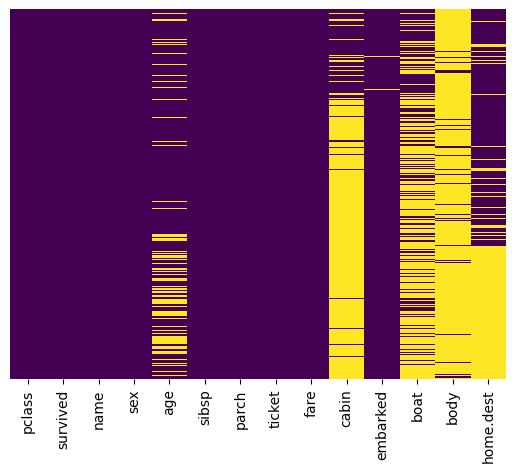

In [4]:
sns.heatmap(datos.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

Aproximadamente el 20% de los datos de **Edad** hacen falta.  Esta proporción probablemente es lo suficientemente pequeño como para llenar valores con alguna forma de imputación.  Si vemos la columna **Cabin**, parece que simplemente hay demasiados datos faltantes como para hacer algo útil, al menos a un nivel básico.  Lo más probable es que botaremos esta columna, o cambiamos el significado a algo como "Cabina conocida:  1 o 0".

Continuemos con más visualizaciones.

<AxesSubplot: xlabel='survived', ylabel='count'>

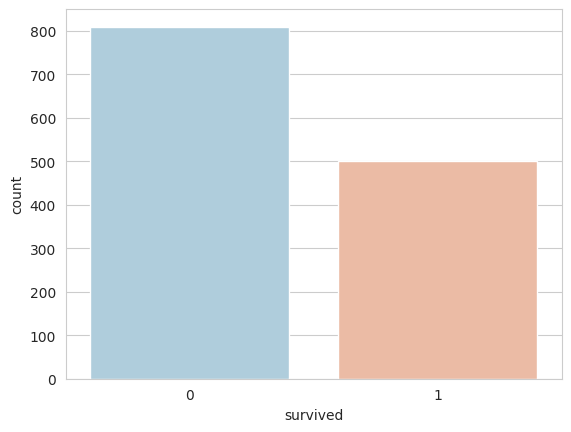

In [5]:
sns.set_style('whitegrid')
sns.countplot(x = 'survived', data = datos, palette = 'RdBu_r')

<AxesSubplot: xlabel='survived', ylabel='count'>

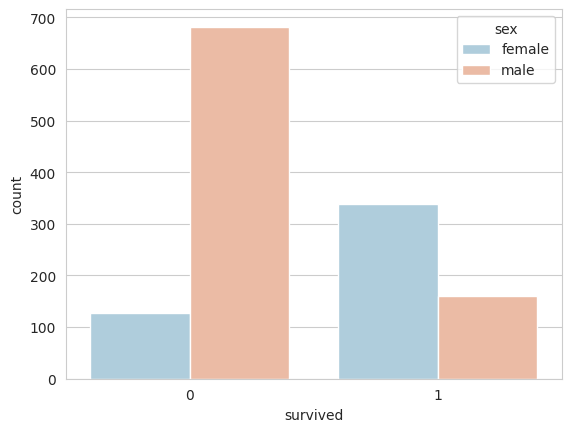

In [6]:
sns.set_style('whitegrid')
sns.countplot(x = 'survived', hue = 'sex', data = datos, palette = 'RdBu_r')

<AxesSubplot: xlabel='survived', ylabel='count'>

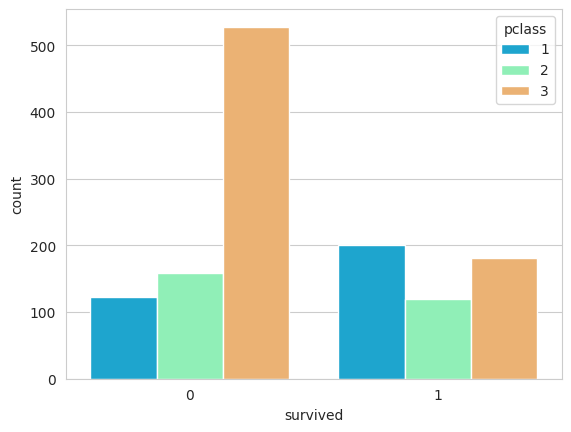

In [7]:
sns.set_style('whitegrid')
sns.countplot(x = 'survived', hue = 'pclass', data = datos, palette = 'rainbow')

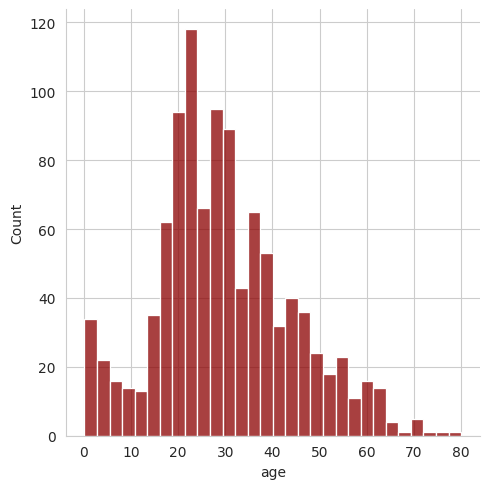

In [8]:
sns.displot(datos['age'].dropna(), color = 'darkred', bins = 30)

In [ ]:
datos['age'].hist(bins = 30, color = 'darkred', alpha = 0.7)

<AxesSubplot: xlabel='sibsp', ylabel='count'>

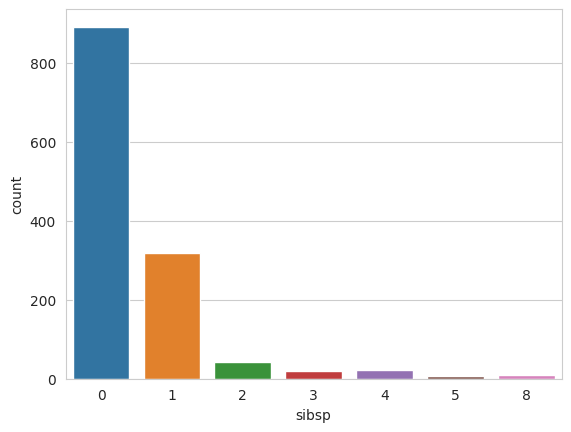

In [9]:
sns.countplot(x = 'sibsp', data = datos)

In [ ]:
datos['fare'].hist(color = 'green', bins = 40, figsize = (8, 4))

___
## Limpieza de datos

Deseamos dar valores a los datos faltante de edad, en vez de solo eliminar las filas que no tengan ese valor.  Una forma de hacerlo es usando la edad promedio de todos los pasajeros (imputación)

Sin embargo, vamos a ser un poco más inteligentes y usaremos la edad promedio por Clase en la que viajan los pasajeros.  Por ejemplo:


,count,mean,std,min,25%,50%,75%,max
pclass,,,,,,,,
1,284.0,39.159918,14.548059,0.9167,28.0,39.0,50.0,80.0
2,261.0,29.506705,13.638628,0.6667,22.0,29.0,36.0,70.0
3,501.0,24.816367,11.958202,0.1667,18.0,24.0,32.0,74.0


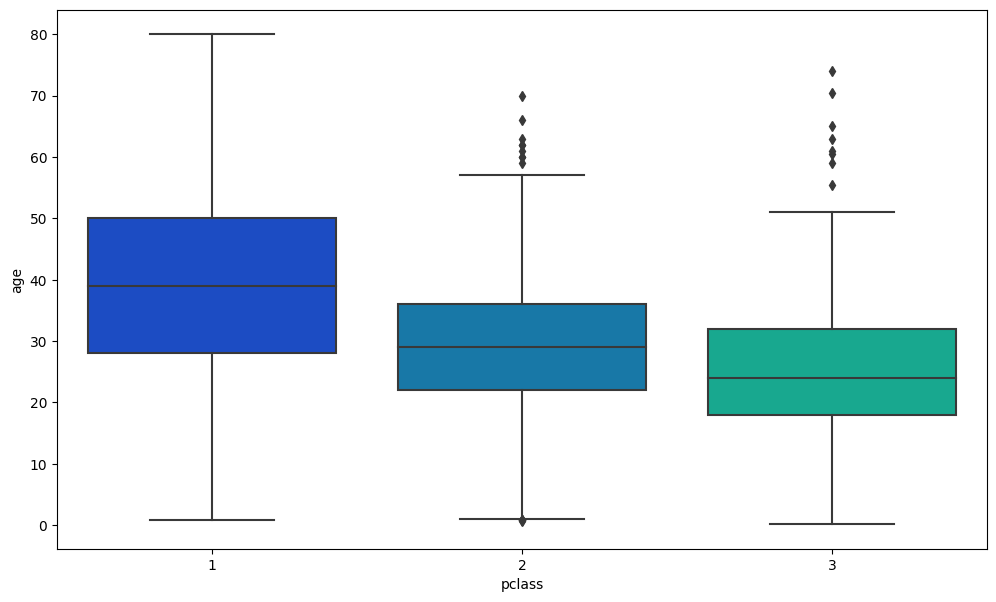

In [7]:
plt.figure(figsize = (12, 7))
sns.boxplot(x = 'pclass', y = 'age', data = datos, palette = 'winter')
datos.groupby('pclass')['age'].describe()

Podemos ver que los pasajeros más "pudientes" en las clases más altas, tienden a ser mayores, que hace mucho sentido.

Utilizaremos estos valores promedio de edad basados en **pclass** para la edad.

In [9]:
def imputar_edad(cols):
    edad = cols[0]
    clase = cols[1]
    
    if pd.isnull(edad):

        if clase == 1:
            return 37

        elif clase == 2:
            return 29

        else:
            return 24

    else:
        return edad

Ahora apliquemos esa función!

In [10]:
datos['age'] = datos[['age','pclass']].apply(imputar_edad, axis = 1)

Veamos el mapa de calor de nuevo!

<AxesSubplot: >

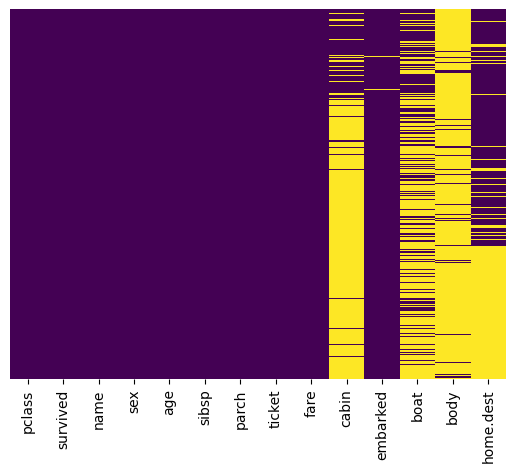

In [11]:
sns.heatmap(datos.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

Fabuloso! Eliminemos la columnas **cabin, boat, body, home.dest** y la fila en **embarked** que tiene un NaN.

In [12]:
datos.drop('cabin', axis = 1, inplace = True)
datos.drop('boat', axis = 1, inplace = True)
datos.drop('body', axis = 1, inplace = True)
datos.drop('home.dest', axis = 1, inplace = True)

In [14]:
datos.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S


In [13]:
datos.dropna(inplace = True)

## Convertir Columnas Categóricas

Será necesario convertir las columnas categóricas a variables "dummy" o comodines utilizando Pandas!  De no hacerlo, nuestro algortimo de Machine Learning no podrá tomar esas columnas como entradas ya que necesita que sean numéricas.



In [15]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1306 non-null   int64  
 1   survived  1306 non-null   int64  
 2   name      1306 non-null   object 
 3   sex       1306 non-null   object 
 4   age       1306 non-null   float64
 5   sibsp     1306 non-null   int64  
 6   parch     1306 non-null   int64  
 7   ticket    1306 non-null   object 
 8   fare      1306 non-null   float64
 9   embarked  1306 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 112.2+ KB


In [16]:
sexo = pd.get_dummies(datos['sex'])

In [17]:
sexo


,female,male
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0
...,...,...
1304,1,0
1305,1,0
1306,0,1
1307,0,1


In [18]:
embarque = pd.get_dummies(datos['embarked'])
embarque

,C,Q,S
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
1304,1,0,0
1305,1,0,0
1306,1,0,0
1307,1,0,0


In [19]:
sexo = pd.get_dummies(datos['sex'], drop_first = True)
embarque = pd.get_dummies(datos['embarked'], drop_first = True)

In [20]:
datos.drop(['sex', 'embarked', 'name', 'ticket'], axis = 1, inplace = True)

In [21]:
datos = pd.concat([datos, sexo, embarque], axis = 1)

In [22]:
datos.head()

,pclass,survived,age,sibsp,parch,fare,male,Q,S
0,1,1,29.0000,0,0,211.3375,0,0,1
1,1,1,0.9167,1,2,151.5500,1,0,1
2,1,0,2.0000,1,2,151.5500,0,0,1
3,1,0,30.0000,1,2,151.5500,1,0,1
4,1,0,25.0000,1,2,151.5500,0,0,1


Ahora sí, nuestros datos están listos para modelar!

# Preparar un modelo de Regresión Logística

Iniciemos con dividir nuestros datos en un cojunto para entrenar (training) y otro para probar (test).

## Partir en Train / Test

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_entreno, X_prueba, y_entreno, y_prueba = train_test_split(datos.drop('survived' , axis = 1), 
                                                    datos['survived'], test_size = 0.30, 
                                                    random_state = 101)

## Entrenamiento y Predicción

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
modeloLog = LogisticRegression(max_iter = 500)
modeloLog.fit(X_entreno,y_entreno)

LogisticRegression(max_iter=500)

In [27]:
predicciones = modeloLog.predict(X_prueba)

Pasémos a evaluar el modelo!

## Evaluación

Podemos chequear:  precision, recall y f1-score utilizando **classification report**!

In [28]:
from sklearn.metrics import classification_report

In [29]:
print(classification_report(y_prueba, predicciones))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       247
           1       0.74      0.74      0.74       145

    accuracy                           0.81       392
   macro avg       0.79      0.79      0.79       392
weighted avg       0.81      0.81      0.81       392



No está mal!  Puede que desee explorar otras formas de organizar los datos (feature engineering), algunas sugerencias de trabajar los datos:

* Intente extraer el título (Dr., Mr., Mrs, etc.) de el nombre, y dejarlo como otra columna
* Quizás la letra de la Cabina podría ser una variable importante
* ¿Hay alguna información de el **ticket** que podría ser útil?

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [32]:
confusion_matrix(y_prueba,predicciones)

array([[210,  37],
       [ 38, 107]])

In [33]:
accuracy_score(y_prueba, predicciones)

0.8086734693877551